# Import

In [1]:
import glob
import os, sys
import shutil
from typing import Callable
from IPython.display import  Markdown, display, display_html

##os.getcwd()
if "../scripts/" not in sys.path:  # to prevent multi adding  
    sys.path.append("../scripts/")
     
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

from eda.helpers import StockOLHCV
from input_output_plot.printing import output_formatting, display_df_side_by_side
from consts import format, color, del_format, data_dir, results_dir, pkl_dir

# Load data

In [2]:
from input_output_plot.file_io import fetch_file, unzip_file

In [3]:
stock_file_path = os.path.join(data_dir, 'all_stocks_5yr.csv')
history_file_path = os.path.join(data_dir, 'HistoricalPrices.csv')
if not os.path.exists(stock_file_path) or not os.path.exists(history_file_path):
    file_path = fetch_file('https://assets.01-edu.org/ai-branch/project4/project04-20221031T173034Z-001.zip', data_dir)
    unzip_file(file_path, data_dir)
    #move csv files directly to data directory
    for filename in glob.iglob('**', root_dir=data_dir, recursive=True):
        if filename.endswith(".csv") and os.sep in filename:
            destination = os.path.join(data_dir,os.path.split(filename)[1])
            if not os.path.exists(destination):
                shutil.move(os.path.join(data_dir,filename), destination)

In [4]:
def get_log_converter(prefix: str, to_type: Callable) -> Callable: 
    """
    :returns converter function, which converts data to the type specified in `to_type`. Data which cannot be converted will be printed out in format 'prefix: |data| len(data)=<length of data>'.
    :param prefix: string to add to log of unconverted data 
    :param to_type: type to convert data.
    :return: data converted to type specified in `to_type`
    """
    def converter(data):
        try:
            return to_type(data)
        except Exception:
            if len(data)>0:
                data=f'{color}{data}{del_format}'
            print(f'{prefix}: |{data}| {len(data)=}', end=' :: ')
            return to_type(np.nan)
    return converter

converters = {'open': get_log_converter('open', np.float32), 'high': get_log_converter('high', np.float32), 'low': get_log_converter('low', np.float32), 'close': get_log_converter('close', np.float32)}
print('read all_stocks_5yr')
df_stocks = pd.read_csv(
        stock_file_path,
        #index_col='date',
        converters=converters,
        dtype={'volume': np.uint32, 'Name': str},
        sep=',',
        #parse_dates=True,
        #date_format='%Y-%m-%d',
    )

print('\nread HistoricalPrices')
df_history = pd.read_csv(
        history_file_path,
        #index_col=['Date'],
        converters=converters,
        sep=',',
        #parse_dates=True,
        #date_format="%m/%d/%y",
    )
print('', end='\n')

read all_stocks_5yr
open: || len(data)=0 :: high: || len(data)=0 :: low: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: high: || len(data)=0 :: high: || len(data)=0 :: low: || len(data)=0 :: low: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: high: || len(data)=0 :: high: || len(data)=0 :: low: || len(data)=0 :: low: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: open: || len(data)=0 :: high: || len(data)=0 :: high: || len(data)=0 :: high: || len(data)=0 :: low: || len(data)=0 :: low: || len(data)=0 :: low: || len(data)=0 :: 
read HistoricalPrices



In [5]:
df_stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float32
 2   high    619032 non-null  float32
 3   low     619032 non-null  float32
 4   close   619040 non-null  float32
 5   volume  619040 non-null  uint32 
 6   Name    619040 non-null  object 
dtypes: float32(4), object(2), uint32(1)
memory usage: 21.3+ MB


In [6]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2580 non-null   object 
 1    Open   2580 non-null   float64
 2    High   2580 non-null   float64
 3    Low    2580 non-null   float64
 4    Close  2580 non-null   float64
dtypes: float64(4), object(1)
memory usage: 100.9+ KB


In [7]:
df_history.rename(columns={k: k.strip().lower() for k in df_history.columns}, inplace=True)

## Set Date as DatetimeIndex

### stocks

In [8]:
df_stocks['date'] = pd.to_datetime(df_stocks['date'],
        errors='raise',
        yearfirst=True,
        format='%Y-%m-%d',)
df_stocks = StockOLHCV(df_stocks.set_index(['date','Name']))
n_stocks = len(df_stocks) 
df_stocks.info()

<class 'eda.helpers.StockOLHCV'>
MultiIndex: 619040 entries, (Timestamp('2013-02-08 00:00:00'), 'AAL') to (Timestamp('2018-02-07 00:00:00'), 'ZTS')
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    619029 non-null  float32
 1   high    619032 non-null  float32
 2   low     619032 non-null  float32
 3   close   619040 non-null  float32
 4   volume  619040 non-null  uint32 
dtypes: float32(4), uint32(1)
memory usage: 14.2+ MB


In [9]:
print(f'Number of companies: {output_formatting(len(df_stocks.names().unique()), format)}')

Number of companies: 505


In [10]:
df_stocks.head()

,,open,high,low,close,volume
date,Name,,,,,
2013-02-08,AAL,15.07,15.12,14.63,14.75,8407500
2013-02-11,AAL,14.89,15.01,14.26,14.46,8882000
2013-02-12,AAL,14.45,14.51,14.10,14.27,8126000
2013-02-13,AAL,14.30,14.94,14.25,14.66,10259500
2013-02-14,AAL,14.94,14.96,13.16,13.99,31879900


###  historical prices

In [11]:
df_history['date'] = pd.to_datetime(df_history['date'],
        errors='raise',
        yearfirst=True,
        format='%m/%d/%y',)
df_history.set_index('date', inplace=True)
n_history = len(df_history) 
df_history.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2580 entries, 2022-10-28 to 2012-07-31
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2580 non-null   float64
 1   high    2580 non-null   float64
 2   low     2580 non-null   float64
 3   close   2580 non-null   float64
dtypes: float64(4)
memory usage: 100.8 KB


In [12]:
df_history.head()

,open,high,low,close
date,,,,
2022-10-28,3808.26,3905.42,3808.26,3901.06
2022-10-27,3834.69,3859.95,3803.79,3807.30
2022-10-26,3825.97,3886.15,3824.07,3830.60
2022-10-25,3799.44,3862.85,3799.44,3859.11
2022-10-24,3762.01,3810.74,3741.65,3797.34


In [13]:
df_history = df_history.sort_index()

# EDA

In [14]:
from scipy import stats
from input_output_plot.plotting import plot_small_term_orgs, plot_outliers_OLHC_to_pdf, scatter_Volume, plot_volume_z_scores, plot_outliers_Volume_to_pdf

from helpers import find_first_diff
from eda.nan_handling import fillmark_nan_with_neighbors_mean, zero2mean
from eda.transforming import OutliersTransformer, create_features

In [15]:
df_stocks.describe()

,open,high,low,close,volume
count,619029.000000,619032.000000,619032.000000,619040.000000,6.190400e+05
mean,83.023331,83.778313,82.256081,83.043762,4.321823e+06
std,97.378769,98.207520,96.507423,97.389748,8.693610e+06
min,1.620000,1.690000,1.500000,1.590000,0.000000e+00
25%,40.220001,40.619999,39.830002,40.244999,1.070320e+06
50%,62.590000,63.150002,62.020000,62.619999,2.082094e+06
75%,94.370003,95.180000,93.540001,94.410004,4.284509e+06
max,2044.000000,2067.989990,2035.109985,2049.000000,6.182376e+08


In [16]:
name_grouped = df_stocks.groupby('Name')

## Complement

### Stock

#### NaN values

In [17]:
mask_0 = df_stocks[['open', 'high', 'low', 'close', 'volume']] == 0
df_stocks[mask_0.any(axis=1)]

,,open,high,low,close,volume
date,Name,,,,,
2016-01-12,DHR,NaN,NaN,NaN,88.550003,0
2016-07-01,FTV,NaN,NaN,NaN,49.540001,0
2016-01-12,O,NaN,NaN,NaN,52.430000,0
2016-04-07,UA,NaN,NaN,NaN,41.560001,0


In [18]:
na_mask = df_stocks.isna().any(axis=1)
df_stocks_nan = df_stocks[na_mask]
df_stocks_nan

,,open,high,low,close,volume
date,Name,,,,,
2017-07-26,BHF,NaN,NaN,NaN,69.084198,3
2015-07-17,DHR,NaN,88.760002,88.239998,88.720001,2056819
2016-01-12,DHR,NaN,NaN,NaN,88.550003,0
2015-07-17,ES,NaN,48.490002,47.849998,47.919998,1246786
2016-07-01,FTV,NaN,NaN,NaN,49.540001,0
2015-07-17,O,NaN,47.310001,46.830002,46.990002,1229513
2016-01-12,O,NaN,NaN,NaN,52.430000,0
2015-06-09,REGN,NaN,NaN,NaN,526.090027,12135
2016-04-07,UA,NaN,NaN,NaN,41.560001,0


It appears that checking Nan values in 'open' column is sufficient to get NaN or zero value in any columns.

What if fill NaN with mean of values of the previous and next day (with respect to the company):

In [19]:
print('What will happen if NaN is filled with mean of values of the previous and next day (with respect to the company)')
print('In the table below `*` marks replaced values. Columns `X/close` shows ratio the corresponding price to close price.')
df_neighbors_means = fillmark_nan_with_neighbors_mean(df_stocks_nan, name_grouped)
df_neighbors_means

What will happen if NaN is filled with mean of values of the previous and next day (with respect to the company)
In the table below `*` marks replaced values. Columns `X/close` shows ratio the corresponding price to close price.


,,open,open/close,high,high/close,low,low/close,close,volume
date,Name,,,,,,,,
2017-07-26,BHF,69.1981*,1.0016*,69.1981*,1.0016*,68.475*,0.9912*,69.084198,3.0
2015-07-17,DHR,88.7*,0.9998*,88.760002,1.000451,88.239998,0.99459,88.720001,2056819.0
2016-01-12,DHR,89.01*,1.0052*,89.155*,1.0068*,87.0*,0.9825*,88.550003,3153984.5*
2015-07-17,ES,47.765*,0.9968*,48.490002,1.011895,47.849998,0.998539,47.919998,1246786.0
2016-07-01,FTV,nan*,nan*,nan*,nan*,nan*,nan*,49.540001,nan*
2015-07-17,O,46.855*,0.9971*,47.310001,1.00681,46.830002,0.996595,46.990002,1229513.0
2016-01-12,O,51.92*,0.9903*,52.8525*,1.0081*,51.5*,0.9823*,52.43,2434892.0*
2015-06-09,REGN,523.355*,0.9948*,528.865*,1.0053*,512.0812*,0.9734*,526.090027,12135.0
2016-04-07,UA,nan*,nan*,nan*,nan*,nan*,nan*,41.560001,nan*


Some companies have NaN values in their first record. 
So I will 
- fill zeros in `volume` column with the mean of the previous and/or next values, depending on their existing;
- fill NaN in `open`, `high` and `low` with the value in `close` column.

Fill NaN

In [20]:
df_stocks_filled = StockOLHCV(df_stocks)
df_stocks_filled['open'] = df_stocks_filled['open'].fillna(df_stocks_filled['close'], axis=0)
df_stocks_filled['low'] = df_stocks_filled['low'].fillna(df_stocks_filled['close'], axis=0)
df_stocks_filled['high'] = df_stocks_filled['high'].fillna(df_stocks_filled['close'], axis=0)

Fill 0 in the volume column

In [21]:
df_stocks_filled['volume']=name_grouped['volume'].transform(zero2mean)
df_stocks_filled[na_mask]

,,open,high,low,close,volume
date,Name,,,,,
2017-07-26,BHF,69.084198,69.084198,69.084198,69.084198,3
2015-07-17,DHR,88.720001,88.760002,88.239998,88.720001,2056819
2016-01-12,DHR,88.550003,88.550003,88.550003,88.550003,3153984
2015-07-17,ES,47.919998,48.490002,47.849998,47.919998,1246786
2016-07-01,FTV,49.540001,49.540001,49.540001,49.540001,6230697
2015-07-17,O,46.990002,47.310001,46.830002,46.990002,1229513
2016-01-12,O,52.430000,52.430000,52.430000,52.430000,2434892
2015-06-09,REGN,526.090027,526.090027,526.090027,526.090027,12135
2016-04-07,UA,41.560001,41.560001,41.560001,41.560001,3602269


In [22]:
df_stocks_filled_groupped = df_stocks_filled.groupby('Name')

#### not the entire term companies

In [23]:
sizes = df_stocks_filled_groupped.agg(n_days=pd.NamedAgg(column='close', aggfunc='size'), 
                                start=pd.NamedAgg(column='close', aggfunc=lambda gr: gr.index.get_level_values('date')[0]), 
                                end=pd.NamedAgg(column='close', aggfunc=lambda gr: gr.index.get_level_values('date')[-1]))
max_term = sizes['n_days'].max()
small_term_orgs = sizes[sizes['n_days'] < max_term]
small_term_orgs.sort_values('n_days').T.style.format(lambda d: d.strftime('%Y/%m/%d') if isinstance(d, pd.Timestamp) else d)

Name,APTV,DWDP,BHF,BHGE,DXC,HLT,EVHC,FTV,UA,WLTW,CSRA,HPE,HPQ,KHC,PYPL,WRK,QRVO,CFG,SYF,INFO,NAVI,GOOG,ALLE,FOXA,NWS,FOX,NWSA,COTY,IQV,DHR,O,ES,ICE,BMY,ORCL
n_days,44,109,143,152,215,276,297,404,464,528,561,581,581,655,655,662,781,850,888,917,960,975,1063,1169,1169,1169,1169,1173,1197,1243,1243,1249,1254,1257,1257
start,2017/12/05,2017/09/01,2017/07/17,2017/07/03,2017/04/03,2017/01/04,2016/12/02,2016/07/01,2016/04/07,2016/01/05,2015/11/16,2015/10/19,2015/10/19,2015/07/06,2015/07/06,2015/06/24,2015/01/02,2014/09/24,2014/07/31,2014/06/19,2014/04/17,2014/03/27,2013/11/18,2013/06/19,2013/06/19,2013/06/19,2013/06/19,2013/06/13,2013/05/09,2013/02/08,2013/02/08,2013/02/08,2013/02/08,2013/02/08,2013/02/08
end,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07,2018/02/07


In [24]:
print(f"The latest start of the companies' periods is {color}{small_term_orgs['start'].max()}{del_format}")
print(f"The earliest end of the companies' periods is {color}{small_term_orgs['end'].min()}{del_format}")

The latest start of the companies' periods is 2017-12-05 00:00:00
The earliest end of the companies' periods is 2018-02-07 00:00:00


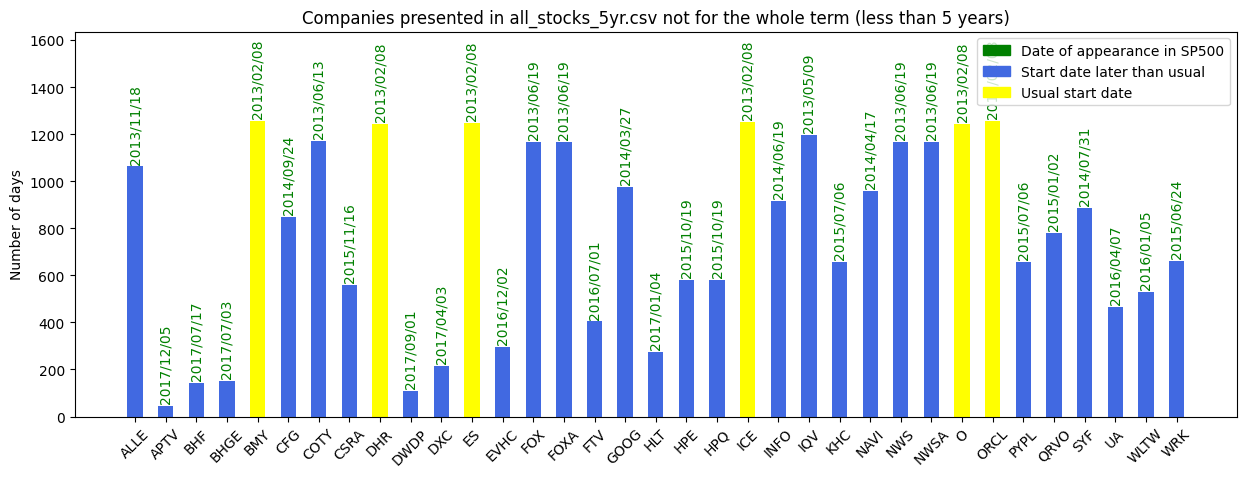

In [25]:
bar_colors = (small_term_orgs['start']==df_stocks_filled.dates().min()).map({True: 'yellow', False: 'royalblue'})
fig = plot_small_term_orgs(small_term_orgs, bar_colors, max_term)
display(fig)

Number of "part-term" companies is quite small regarding the total number of companies, so they shouldn't have large effect on results.  

### Historical price

In [26]:
history_describe = df_history.describe()
history_describe

,open,high,low,close
count,2580.000000,2580.000000,2580.000000,2580.000000
mean,2668.891535,2683.109996,2653.527465,2669.310942
std,886.954372,893.322607,879.870553,886.795301
min,1353.360000,1360.620000,1343.350000,1353.330000
25%,2002.255000,2016.370000,1991.627500,2001.712500
50%,2475.750000,2481.465000,2464.860000,2475.170000
75%,3140.495000,3153.652500,3126.347500,3134.220000
max,4804.510000,4818.620000,4780.040000,4796.560000


There are no NaN values in the historical price set.

## Consistent inervals

### Gaps in periods

In [27]:
print('Gap in historical dates in 5 days or more')
df_history['gap'] = df_history.index.diff(1)
df_history[df_history['gap']>=np.timedelta64(5,'D')]


Gap in historical dates in 5 days or more


,open,high,low,close,gap
date,,,,,
2012-10-31,1410.99,1418.76,1405.95,1412.16,5 days


In [28]:
def gap_in_days(df, days=5):
    df['gap'] = df.index.get_level_values('date').diff(1)
    return df[df['gap']>=np.timedelta64(5,'D')]
orgs_gaps = df_stocks_filled_groupped.apply(gap_in_days, include_groups=False, days=5)
max_gap_size= orgs_gaps['gap'].max()
orgs_gaps

open       high        low      close    volume  \
Name date       Name                                                         
DHR  2013-09-12 DHR   69.370003  69.550003  69.050003  69.449997   2498391   
     2015-03-23 DHR   87.389999  87.500000  86.750000  86.769997   2807476   
ES   2015-03-23 ES    51.110001  51.610001  51.029999  51.470001   1197822   
ICE  2013-09-12 ICE   36.394001  36.394001  35.930000  36.000000   2688625   
O    2013-09-12 O     39.680000  39.849998  39.169998  39.220001   1189250   
     2015-03-23 O     53.549999  54.080002  53.310001  53.459999   1319789   
ORCL 2013-07-17 ORCL  32.070000  32.439999  32.049999  32.160000  22357845   

                         gap  
Name date       Name          
DHR  2013-09-12 DHR   6 days  
     2015-03-23 DHR  17 days  
ES   2015-03-23 ES   17 days  
ICE  2013-09-12 ICE   6 days  
O    2013-09-12 O     6 days  
     2015-03-23 O    17 days  
ORCL 2013-07-17 ORCL  5 days

### Compare dates in stock and history sets

In [29]:
def compare_dates_to_history(df):
    
    def get_less_more_sets(di1,di2, first):
        if len(di1) < len(di2):
            return (1, set(di1[first:]), set(di2[first:]))
        else:
            return (0, set(di1[first:]), set(di2[first:]))
        
    def get_diff_items(set1,set2):
        if len(set1) > len(set2):
            raise ValueError("len of the first given set must be less than second set's length")
        diff1=set()
        while len(set1)>0:
            item = set1.pop()
            if item in set2:
                set2.remove(item)
            else:
                diff1.append(item)
        return diff1,set2
    
    min_stock_date=df.index.get_level_values('date').min()
    max_stock_date=df.index.get_level_values('date').max()
    hist_dates = df_history[min_stock_date:max_stock_date].index.get_level_values('date')
    first_diff=find_first_diff(df.index.get_level_values('date'), hist_dates)
    sign, set1,set2 = get_less_more_sets(df.index.get_level_values('date'),hist_dates,first_diff)
    if sign==1:
        set1,set2 = get_diff_items(set1,set2)
    else:
        set2,set1 = get_diff_items(set2,set1)
        
    return pd.Series({'df_dates': set1, 'history_dates': set2, 'df_total_days': len(df)})

In [30]:
def count_gaps(gr):
    gaps = compare_dates_to_history(gr)
    for key in ['df_dates', 'history_dates']:
        gaps[key] = len(gaps[key])
    gaps['gaps_of_total_days,%'] = gaps[['df_dates','history_dates']].sum()/gaps['df_total_days']
    return gaps
diff_dates = df_stocks_filled_groupped.apply(count_gaps,include_groups=False)
display(Markdown("Compare dates for each company in the stocks set(`df_stocks`) to dates in the history price set(`df_history`) (for each company consider history period that matches the company's period in the stock set). The column `history_dates` corresponds `df_history` set and the column `df_dates` corresponds `df_stocks`. The columns show how many days are presented in the corresponding set's period which are absented in the other set." ))
diff_dates[diff_dates['gaps_of_total_days,%']>0]

Compare dates for each company in the stocks set(`df_stocks`) to dates in the history price set(`df_history`) (for each company consider history period that matches the company's period in the stock set). The column `history_dates` corresponds `df_history` set and the column `df_dates` corresponds `df_stocks`. The columns show how many days are presented in the corresponding set's period which are absented in the other set.

,df_dates,history_dates,df_total_days,"gaps_of_total_days,%"
Name,,,,
BMY,0,2,1257,0.001591
DHR,0,16,1243,0.012872
ES,0,10,1249,0.008006
ICE,0,5,1254,0.003987
O,0,16,1243,0.012872
ORCL,0,2,1257,0.001591


The gaps take quite small part of a company's total period, so they shouldn't have large effect on results.  

## Duplicates

In [31]:
print(f'Are there any {color}duplicate{del_format} dates for any companies in stocks set?')
df_stocks_filled_groupped.apply(lambda gr: gr.index.get_level_values('date').duplicated(keep=False).sum(),include_groups=False).sum()!=0

Are there any duplicate dates for any companies in stocks set?


np.False_

In [32]:
print(f'Are there any {color}duplicate{del_format} dates in history price set?')
df_history.index.duplicated(keep=False).sum()!=0

Are there any duplicate dates in history price set?


np.False_

## Outliers

Anilize outliers for train part of the data. The method chosen to handle outliers will be applied to the data in the test set.

In [33]:
train_set = StockOLHCV(df_stocks_filled[df_stocks_filled.dates()<np.datetime64('2017-01-01')])
train_set_name_grouped = train_set.groupby('Name')

In [34]:
#print("Companies which have stocks' price greater than 500 ")
price500 = (train_set['close'][train_set['close']>500].groupby('Name').count().sort_values(ascending=False).reset_index()
            .rename(columns={'Name': 'large 500: Name', 'close':'count days with close greater than 500'}))
largest = (train_set_name_grouped['close'].agg(['mean', 'max']).sort_values(by='mean', ascending=False)[:10].reset_index()
           .rename(columns={'Name': 'largest: Name', 'mean':'largest: close mean', 'max':'largest: close max'}))
# Convert DataFrames to HTML and display side by side
display_df_side_by_side([price500, largest], ['Companies which have stocks\' price greater than 500', 'Companies with the biggest mean of close price'])

Companies which have stocks' price greater than 500 
 
 
   
 large 500: Name 
 count days with close greater than 500 
 
 
 
 
 0 
 PCLN 
 982 
 
 
 1 
 GOOGL 
 805 
 
 
 2 
 AZO 
 737 
 
 
 3 
 GOOG 
 694 
 
 
 4 
 CMG 
 559 
 
 
 5 
 AMZN 
 355 
 
 
 6 
 REGN 
 147 
 
 
 

 
 Companies with the biggest mean of close price 
 
 
   
 largest: Name 
 largest: close mean 
 largest: close max 
 
 
 
 
 0 
 PCLN 
 1173.518799 
 1578.130005 
 
 
 1 
 GOOG 
 639.957581 
 813.109985 
 
 
 2 
 AZO 
 610.407349 
 815.979980 
 
 
 3 
 GOOGL 
 604.500000 
 835.739990 
 
 
 4 
 CMG 
 527.365662 
 757.770020 
 
 
 5 
 AMZN 
 456.952301 
 844.359985 
 
 
 6 
 REGN 
 371.766632 
 592.400024 
 
 
 7 
 BLK 
 323.997375 
 398.450012 
 
 
 8 
 MTD 
 295.858734 
 429.910004 
 
 
 9 
 BIIB 
 295.287537 
 475.980011

The top 7 companies in these 2 lists are the same.

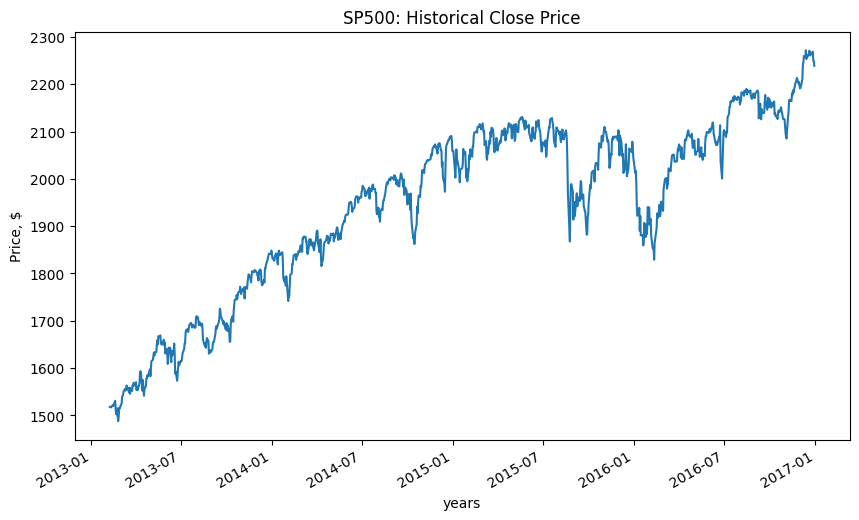

In [35]:
df_history['close'].loc['2013-02-08':'2017-01-01'].plot(figsize=(10,6), title='SP500: Historical Close Price', xlabel='years', ylabel='Price, $')
plt.show()

In [36]:
# Z-score method = normalization(it uses numpy std, which is calculated with  ddof=0, while panda uses  ddof=1 by default)
_z_scores = StockOLHCV(train_set_name_grouped.transform(stats.zscore))

### Open, High, Low, Close

In [80]:
olhc_cols = ['open', 'low', 'high', 'close']
data_outliers_dir = os.path.join(results_dir, 'data_outliers')
os.makedirs(data_outliers_dir, exist_ok=True)
outliers_file_name = os.path.join(data_outliers_dir, 'OLHC_outliers_z_score4.pdf')
print('Plots of companies with biggest outliers in Open, High, Low, Close are saved into ', output_formatting(outliers_file_name, format))
#print('Three of them are showed bellow')
outliers_z_score_OHLC = StockOLHCV(_z_scores[olhc_cols][_z_scores.abs() > 4].dropna(how='all'))
plot_outliers_OLHC_to_pdf(outliers_z_score_OHLC, train_set, outliers_file_name)

Plots of companies with biggest outliers in Open, High, Low, Close are saved into  ../results/data_outliers\OLHC_outliers_z_score4.pdf


Outliers here reflect market changes rather than errors, except for low prices on 2 days of companies 'VZ' and 'XL'. 

In [81]:
print('Z-Scores of Low price for companies with `VZ` and `XL`')
outliers_z_score_OHLC[outliers_z_score_OHLC.names().isin(['VZ', 'XL'])]

Z-Scores of Low price for companies with `VZ` and `XL`


open       low  high  close
date       Name                             
2015-08-24 VZ     NaN -4.181252   NaN    NaN
           XL     NaN -9.630431   NaN    NaN

In general the prices increase over time. Therefore negative limit of z-score should be large than the positive one to consider a value as an outlier. Let's check tendents of negative z-scores for OLHC prices.

In [82]:
display_df_side_by_side([_z_scores[olhc_cols][(_z_scores[olhc_cols] < -3.2).sum(axis=1)>0], _z_scores[olhc_cols][(_z_scores[olhc_cols] > 4.6).sum(axis=1)>0]],
                        captions=['Z-Scores of OLHC prices where there are z_scores < -3.2', 'Z-Scores of OLHC prices where there are z_scores > 4.6'])

Z-Scores of OLHC prices where there are z_scores < -3.2 
 
 
   
   
 open 
 low 
 high 
 close 
 
 
 date 
 Name 
   
   
   
   
 
 
 
 
 2015-08-24 00:00:00 
 CL 
 -0.912676 
 -3.274049 
 -0.657124 
 -0.906937 
 
 
 2016-02-11 00:00:00 
 C 
 -3.084987 
 -3.295789 
 -3.167935 
 -3.307481 
 
 
 2015-08-24 00:00:00 
 PG 
 -2.952313 
 -3.651344 
 -2.492455 
 -2.816403 
 
 
 VZ 
 -1.867900 
 -4.181252 
 -1.404291 
 -1.718170 
 
 
 2016-02-09 00:00:00 
 WY 
 -3.241626 
 -3.287637 
 -3.237013 
 -3.266131 
 
 
 2016-02-10 00:00:00 
 WY 
 -3.190851 
 -3.306387 
 -3.249869 
 -3.434806 
 
 
 2016-02-11 00:00:00 
 WY 
 -3.588581 
 -3.539711 
 -3.659911 
 -3.628783 
 
 
 2016-02-12 00:00:00 
 WY 
 -3.525114 
 -3.418882 
 -3.565944 
 -3.468541 
 
 
 2016-02-16 00:00:00 
 WY 
 -3.326249 
 -3.206391 
 -3.032034 
 -2.975165 
 
 
 2016-02-19 00:00:00 
 WY 
 -3.000449 
 -3.289721 
 -3.143088 
 -3.354685 
 
 
 2016-02-22 00:00:00 
 WY 
 -3.233163 
 -3.102229 
 -3.172986 
 -3.055286 
 
 
 2015-08-24 00:00:00 
 XL 
 0.476935 
 -9.630431 
 1.224640 
 1.020677 
 
 
 

 
 Z-Scores of OLHC prices where there are z_scores > 4.6 
 
 
   
   
 open 
 low 
 high 
 close 
 
 
 date 
 Name 
   
   
   
   
 
 
 
 
 2016-12-22 00:00:00 
 AMD 
 4.607635 
 4.653222 
 4.509248 
 4.564999 
 
 
 2016-12-27 00:00:00 
 AMD 
 4.607635 
 4.730147 
 4.695471 
 4.836028 
 
 
 2016-12-28 00:00:00 
 AMD 
 4.971904 
 4.647305 
 4.887337 
 4.536165 
 
 
 2016-12-30 00:00:00 
 AMD 
 4.636546 
 4.523041 
 4.526178 
 4.415067 
 
 
 2016-12-27 00:00:00 
 NVDA 
 4.407397 
 4.457062 
 4.583855 
 4.664125 
 
 
 2016-12-28 00:00:00 
 NVDA 
 4.802299 
 4.322261 
 4.716093 
 4.242931 
 
 
 2016-12-27 00:00:00 
 ZION 
 4.636948 
 4.618402 
 4.536869 
 4.563694 
 
 
 2016-12-28 00:00:00 
 ZION 
 4.616117 
 4.472147 
 4.501321 
 4.371013

**Conclusion:** In most cases z-scores more than -4 or greater 4.5 are correlated among OLHC prices (with only 1 exeption for `CL`company). For companies  `VZ` and `XL` Low prices have z-scores -4.18 and -9.63 respectively and them are not correlated among the others prices (open, high and close).

### Volume

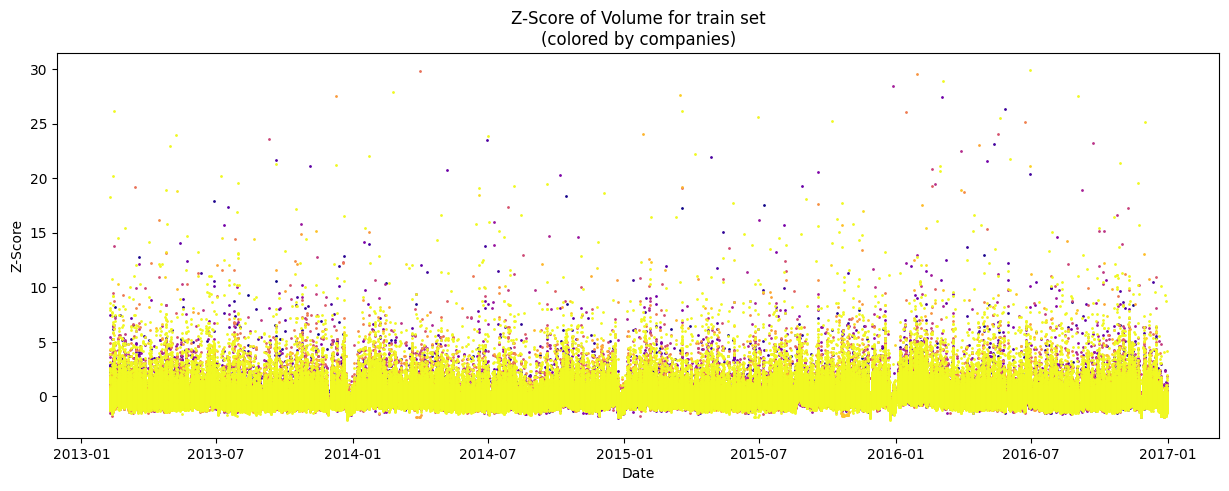

In [83]:
fig = scatter_Volume(_z_scores.groupby('Name'))
display(fig)

In [84]:
outliers_z_score_volume20 = StockOLHCV(_z_scores['volume'][_z_scores['volume'].abs() > 20].dropna())
companies_out_volume20 = outliers_z_score_volume20.names().unique() 
fig_before = plot_volume_z_scores(_z_scores, companies_out_volume20, 'volume', 
                     title="Boxplot of Volumes's Z-scores for Companies which have a z-score > 20",
                     ylabel='Normalized Volume')
#display(fig_before)

In [85]:
outliers_volume_file_name=os.path.join(data_outliers_dir,'Volume_outliers_z_score20.pdf')
print('Plots of companies with biggest volume outliers are saved into ', output_formatting(outliers_volume_file_name, format))
plot_outliers_Volume_to_pdf(companies_out_volume20, _z_scores, outliers_volume_file_name)

Plots of companies with biggest volume outliers are saved into  ../results/data_outliers\Volume_outliers_z_score20.pdf


### Capping outliers

Let's cap OLHC prices with z-scores less than `-4` and greater than `5`. 
The OutliersTransformer replaces 'Open' and  'Close' prices with mean of the other prices(if they are not out of the limits).
'Low' prise is replaced with minimum of the oters and 'High' price is replaced with the maximum.
'Volume' outliers are capped using IQR method with 1st quantile = `0.1`, 2d quantile = `0.9` quantile interval rate = `3.5`.

In [86]:
outlier_transformer = OutliersTransformer()
train_set_removed_outliers = outlier_transformer.fit_transform(train_set)

In [87]:
z_scores1 = train_set_removed_outliers.groupby('Name').transform(stats.zscore)
outliers_z_score_volume8 = StockOLHCV(z_scores1['volume'][z_scores1['volume'].abs() > 8].dropna())
companies_out_volume8 = outliers_z_score_volume8.names().unique()
fig_after = plot_volume_z_scores(z_scores1, companies_out_volume8, 'volume', 
                     title="After capping outliers: Boxplot of Volumes's Z-scores for Companies which have a z-score > 8",
                     ylabel='Normalized Volume')
#display(fig)

In [88]:
outliers_before_after_file_name = os.path.join(data_outliers_dir,'Volume_outliers_before_after_capping.pdf')
with PdfPages(outliers_before_after_file_name) as pdf:
    pdf.savefig(fig_before)
    pdf.savefig(fig_after)
print("Boxplots of Volumes's outliers befor and after capping are saved into ", output_formatting(outliers_before_after_file_name, format))


Boxplots of Volumes's outliers befor and after capping are saved into  ../results/data_outliers\Volume_outliers_before_after_capping.pdf


# Features engineering

In [89]:
from input_output_plot.plotting import plot_features_hist, plot_features_count, plot_corr_heatmap, plot_vs_features, plot_boxplot_before_after_capping_outliers
from ta import add_all_ta_features

from sklearn.preprocessing import PowerTransformer, QuantileTransformer

In [90]:
df_history['return'] = (df_history['close'].pct_change(fill_method=None).shift(-2))
df_history.dropna(inplace=True)
df_history[['close', 'return']][-5:]

,close,return
date,,
2022-10-18,3719.98,-0.007951
2022-10-19,3695.16,0.023725
2022-10-20,3665.78,0.011882
2022-10-21,3752.75,0.016267
2022-10-24,3797.34,-0.007388


In [91]:
df_history_file = os.path.join(pkl_dir, 'sp500_history.pkl')
with open(df_history_file, 'wb') as f:
    pickle.dump(df_history, f)
print('df_history is saved into ', output_formatting(df_history_file, format))  

df_history is saved into  ../results/pickled\sp500_history.pkl


## Correliation

### Check correliation among features

In [92]:
def featurizing_all_ta(df):
    x = df.groupby('Name')\
    .apply(add_all_ta_features, open="open", high="high", low="low", close="close", volume="volume", fillna=False)\
    .reset_index(level=0, drop=True)
    na_num = x.isna().sum()
    too_many_na = na_num[na_num > na_num['trend_macd']].index
    x = x.drop(columns=too_many_na)\
    .drop(columns=['open', 'high', 'low', 'close', 'volume'])\
    .dropna(axis='index', how='any')\
    .reset_index(level='Name', drop=True)
    return x, too_many_na

In [93]:
# take part of data to define which features are useful
import warnings
all_names =train_set_removed_outliers.index.get_level_values('Name')
a_names = all_names[all_names.str.startswith('A')]
x_tmp = train_set_removed_outliers[all_names.isin(a_names)].copy()
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=FutureWarning)
    x_featurized, dropped_many_na = featurizing_all_ta(x_tmp)
x_featurized_all_ta = x_featurized.copy()


In [94]:
dropped_many_na

Index(['trend_macd_signal', 'trend_macd_diff', 'trend_trix',
       'trend_mass_index', 'trend_stc', 'trend_psar_up', 'trend_psar_down',
       'momentum_stoch_rsi', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d',
       'momentum_tsi', 'momentum_uo', 'momentum_ao', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo_signal', 'momentum_pvo_hist'],
      dtype='object')

In [95]:
base_features = ['trend_macd', 'momentum_rsi', 'volatility_bbm','volatility_bbhi', 'volatility_bbli', 'volatility_bbw']

In [96]:
# Calculate the correlation matrix
corr_matrix0 = x_featurized.corr()

Plot examples of different correlated features

In [97]:
corr_dir = os.path.join(results_dir, 'correlations')
os.makedirs(corr_dir, exist_ok=True)
correliations_features_file = os.path.join(corr_dir,'correliations_features.png')
features_x = ['volatility_bbm', 'volatility_bbm', 'momentum_rsi', 'momentum_rsi', 'momentum_ppo', 'momentum_rsi', 'momentum_rsi', 'volatility_bbm']
features_y = ['trend_aroon_down', 'trend_aroon_up', 'trend_aroon_down', 'trend_aroon_up', 'momentum_roc', 'momentum_ppo', 'trend_cci', 'volume_vwap']
fig = plot_vs_features(x_featurized[:3000], features_x, features_y,figsize=(15,10))
fig.savefig(correliations_features_file)
print("Plot of features' correlation is saved into ", output_formatting(correliations_features_file, format))

Plot of features' correlation is saved into  ../results/correlations\correliations_features.png


In [98]:
correlated_features_based = pd.DataFrame(index=x_featurized.columns, columns=base_features)
for feature in x_featurized.columns:
    for base_feature in base_features:
        if base_feature!=feature:
            if abs(corr_matrix0.loc[feature, base_feature]) > 0.68:
                correlated_features_based.loc[feature, base_feature] = corr_matrix0.loc[feature, base_feature]
correlated_features_based.dropna(how='all', inplace=True)
correlated_features_based

,trend_macd,momentum_rsi,volatility_bbm,volatility_bbhi,volatility_bbli,volatility_bbw
volume_vwap,NaN,NaN,0.999845,NaN,NaN,NaN
volume_mfi,NaN,0.745479,NaN,NaN,NaN,NaN
volatility_bbh,NaN,NaN,0.999323,NaN,NaN,NaN
volatility_bbl,NaN,NaN,0.999193,NaN,NaN,NaN
volatility_bbp,NaN,0.887218,NaN,NaN,NaN,NaN
volatility_kcc,NaN,NaN,0.999703,NaN,NaN,NaN
volatility_kch,NaN,NaN,0.999711,NaN,NaN,NaN
volatility_kcl,NaN,NaN,0.999606,NaN,NaN,NaN
volatility_kcp,NaN,0.796631,NaN,NaN,NaN,NaN
volatility_dcl,NaN,NaN,0.999168,NaN,NaN,NaN


In [99]:
col_to_check = [col for col in x_featurized.columns if col not in [*correlated_features_based.index, *base_features]]
features=[]
correlation_coefficients=[]
for i in range(len(col_to_check)):
    for j in range(i):
        correlation_coefficient = corr_matrix0.loc[col_to_check[i], col_to_check[j]]
        if  abs(correlation_coefficient) > 0.68:
            features.append((col_to_check[i], col_to_check[j]))
            correlation_coefficients.append(correlation_coefficient)
correlated_features = pd.DataFrame(correlation_coefficients, index=pd.MultiIndex.from_tuples(features), columns=['corr_coeff'])
correlated_features

,,corr_coeff
trend_kst_sig,trend_kst,0.943633
others_dlr,others_dr,0.998989


In [100]:
features_to_drop = [*correlated_features.index.get_level_values(0).to_list() , *correlated_features_based.index]
x_featurized.drop(columns=features_to_drop, inplace=True)

In [101]:
correlation_05_heatmap_file = os.path.join(corr_dir,'correlation_05_heatmap.png')
corr_matrix1 = x_featurized.corr()
sns_corr1 = plot_corr_heatmap(corr_matrix1[corr_matrix1.abs()>0.5].dropna(how='all', axis=1))
sns_corr1.figure.savefig(correlation_05_heatmap_file)
print("Heatmap of features with correlation greater than 0.5 is saved into ", output_formatting(correlation_05_heatmap_file, format)) 

Heatmap of features with correlation greater than 0.5 is saved into  ../results/correlations\correlation_05_heatmap.png


In [102]:
features_to_drop = ['volatility_kcw', 'volatility_kchi', 'volatility_kcli', 'volatility_ui', 'trend_kst', 'volume_obv']
x_featurized.drop(columns=features_to_drop, inplace=True)
# Calculate the correlation matrix
correlation_heatmap_file = os.path.join(corr_dir,'correlation_heatmap.png')
corr_matrix1 = x_featurized.corr()
sns_corr1 = plot_corr_heatmap(corr_matrix1)
sns_corr1.figure.savefig(correlation_heatmap_file)
print("Heatmap of features' correlation is saved into ", output_formatting(correlation_heatmap_file, format))


Heatmap of features' correlation is saved into  ../results/correlations\correlation_heatmap.png


In [103]:
x_featurized.columns

Index(['volume_adi', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_nvi', 'volatility_bbm', 'volatility_bbw',
       'volatility_bbhi', 'volatility_bbli', 'trend_macd', 'trend_dpo',
       'trend_kst_diff', 'trend_adx', 'trend_aroon_up', 'trend_aroon_down',
       'trend_psar_up_indicator', 'trend_psar_down_indicator', 'momentum_rsi',
       'momentum_pvo', 'others_dr', 'others_cr'],
      dtype='object')

Find indicators among the features

In [104]:
x_featurized.describe().T

,count,mean,std,min,25%,50%,75%,max
volume_adi,53860.0,3.666616e+07,1.272014e+08,-1.456356e+09,1.004547e+07,2.886297e+07,6.361281e+07,5.874482e+08
volume_cmf,53860.0,3.925151e-02,1.537097e-01,-6.507317e-01,-6.591268e-02,3.849316e-02,1.449935e-01,6.361595e-01
volume_fi,53860.0,9.029522e+04,6.737706e+06,-2.345305e+08,-2.954365e+05,5.473516e+04,4.598958e+05,1.987591e+08
volume_em,53860.0,2.569702e+01,3.929924e+03,-2.279601e+05,-2.105125e+01,5.046188e-01,2.963977e+01,1.592761e+05
volume_sma_em,53860.0,2.692309e+01,1.063986e+03,-2.875718e+04,-6.500054e+00,5.037095e-01,1.250001e+01,3.238839e+04
volume_vpt,53860.0,2.011725e+06,7.151136e+06,-2.916722e+07,1.035313e+05,5.562054e+05,1.894358e+06,1.389979e+08
volume_nvi,53860.0,1.399336e+03,3.746930e+02,6.949851e+02,1.114931e+03,1.311795e+03,1.583710e+03,3.296060e+03
volatility_bbm,53860.0,9.528402e+01,1.037759e+02,1.787000e+00,4.722300e+01,6.545150e+01,1.020721e+02,8.300605e+02
volatility_bbw,53860.0,1.015857e+01,6.586376e+00,1.049998e+00,5.836714e+00,8.529649e+00,1.250021e+01,8.368712e+01
volatility_bbhi,53860.0,6.687709e-02,2.498113e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [105]:
describe_df = x_featurized.describe()
indicators = describe_df.columns[(describe_df.loc['min']==0)&(describe_df.loc['max']==1)]
x_featurized[indicators][-5:]

,volatility_bbhi,volatility_bbli,trend_psar_up_indicator,trend_psar_down_indicator
date,,,,
2016-12-23,0.0,0.0,0.0,0.0
2016-12-27,0.0,0.0,0.0,0.0
2016-12-28,0.0,0.0,0.0,0.0
2016-12-29,0.0,0.0,0.0,0.0
2016-12-30,0.0,0.0,0.0,1.0


In [106]:
x_featurized[['trend_aroon_down', 'trend_aroon_up']][:10].T

date,2013-03-18,2013-04-24,2013-04-25,2013-04-26,2013-04-29,2013-04-30,2013-05-01,2013-05-02,2013-05-03,2013-05-06
trend_aroon_down,44.0,40.0,36.0,32.0,28.0,24.0,20.0,16.0,12.0,8.0
trend_aroon_up,0.0,68.0,64.0,60.0,56.0,52.0,48.0,44.0,40.0,36.0


### Features with correliaton between 0.5 and 0.7 

In [107]:
corr_matrix0['volume_adi']['momentum_rsi']

np.float64(0.026462409007156632)

In [108]:
unused_features = set()
for feature_used in x_featurized.columns:
    for feature in corr_matrix0.columns:
        if feature not in x_featurized.columns and abs(corr_matrix0.loc[feature_used, feature]) > 0.5 and abs(corr_matrix0.loc[feature_used, feature]) < 0.7:
            # print(f'Correlation between {feature_used} and {feature} is {corr_matrix0.loc[feature_used, feature]}')
            unused_features.add(feature)
unused_features = list(unused_features)

In [109]:

correlation_unused_heatmap_file = os.path.join(corr_dir,'correlation_unused_heatmap.png')
corr_matrix_unused = corr_matrix0.loc[(unused_features),unused_features]
sns_corr_unused = plot_corr_heatmap(corr_matrix_unused)
sns_corr_unused.figure.savefig(correlation_unused_heatmap_file)
print("Heatmap of unused features' correliations is saved into ", output_formatting(correlation_unused_heatmap_file, format)) 

Heatmap of unused features' correliations is saved into  ../results/correlations\correlation_unused_heatmap.png


In [110]:
unused_features

['volatility_kcli',
 'volatility_ui',
 'volume_mfi',
 'momentum_stoch',
 'trend_adx_pos',
 'trend_vortex_ind_pos',
 'volatility_dcp',
 'volatility_kchi',
 'trend_kst',
 'momentum_ppo',
 'trend_vortex_ind_diff',
 'trend_kst_sig',
 'trend_cci',
 'momentum_wr',
 'volume_obv',
 'volatility_kcw',
 'trend_vortex_ind_neg',
 'momentum_stoch_signal',
 'trend_aroon_ind',
 'volatility_bbp',
 'trend_adx_neg']

In [111]:
addition_features = ['volatility_kcli', 'trend_kst_sig', 'volatility_kchi', 'trend_aroon_ind', 'volatility_kcw', 'volume_obv', 'trend_cci', 'volatility_ui']

In [112]:
x_featurized_all_ta[addition_features].describe().T

,count,mean,std,min,25%,50%,75%,max
volatility_kcli,53860.0,1.682696e-01,3.741090e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
trend_kst_sig,53860.0,1.474561e+01,5.953206e+01,-4.578994e+02,-1.904842e+01,1.496093e+01,4.848908e+01,5.306547e+02
volatility_kchi,53860.0,2.513368e-01,4.337858e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
trend_aroon_ind,53860.0,1.361196e+01,6.130236e+01,-1.000000e+02,-4.400000e+01,3.200000e+01,6.800000e+01,1.000000e+02
volatility_kcw,53860.0,4.059224e+00,1.704929e+00,1.186420e+00,2.917463e+00,3.633627e+00,4.722024e+00,2.090770e+01
volume_obv,53860.0,1.117199e+08,2.060563e+08,-1.094035e+09,2.098427e+07,5.130704e+07,1.095000e+08,2.663928e+09
trend_cci,53860.0,1.770365e+01,1.115866e+02,-6.446685e+02,-6.656427e+01,3.296854e+01,1.012478e+02,5.829541e+02
volatility_ui,53860.0,3.448225e+00,2.923195e+00,0.000000e+00,1.436982e+00,2.596409e+00,4.586661e+00,3.461847e+01


In [113]:
describe_df = x_featurized_all_ta[addition_features].describe()
indicators_addition = describe_df.columns[(describe_df.loc['min']==0)&(describe_df.loc['max']==1)]
x_featurized_all_ta[indicators_addition][-5:]

,volatility_kcli,volatility_kchi
date,,
2016-12-23,0.0,0.0
2016-12-27,0.0,0.0
2016-12-28,0.0,0.0
2016-12-29,0.0,0.0
2016-12-30,0.0,0.0


In [114]:
x_featurized_all_ta['trend_aroon_ind'][:10]

date
2013-03-18   -44.0
2013-04-24    28.0
2013-04-25    28.0
2013-04-26    28.0
2013-04-29    28.0
2013-04-30    28.0
2013-05-01    28.0
2013-05-02    28.0
2013-05-03    28.0
2013-05-06    28.0
Name: trend_aroon_ind, dtype: float64

## Train set

In [115]:
def featurizing(df, addition_features=None):
    x = df.groupby('Name')\
    .apply(create_features).reset_index(level=0, drop=True)\
    .dropna(axis='index', how='any')\
    .reset_index(level='Name')\
    .sort_index()
    return_df = x[['Name', 'return']].copy()
    x = x.drop(columns='return')
    y = return_df['return'].map(lambda x: 1 if x>0 else 0)
    y.name = 'signal'
    if addition_features is not None:
        x_addition = x[addition_features].copy()
        x_addition['Name'] = x['Name'].copy()
        x = x.drop(columns=addition_features)
    else:
        x_addition = None

    return x, y, return_df, x_addition


addition_features_ = ['keltner_channel_lband_indicator', 'keltner_channel_hband_indicator', 'keltner_channel_width', 'ulcer_index', 
                     'kst_sig', 'Aroon_ind', 'cci', 'obv']

In [116]:
recalculate = False
X_train_file = os.path.join(pkl_dir, 'x_train_features.pkl')
X_train_addition_file = os.path.join(pkl_dir, 'x_train_addition_features.pkl')
y_train_file = os.path.join(pkl_dir, 'y_train_features.pkl')
X_train_return_file = os.path.join(pkl_dir, 'x_train_return_features.pkl')

if recalculate or not os.path.exists(X_train_file):
    X_train, y_train, X_train_return, X_train_addition = featurizing(train_set_removed_outliers, addition_features_)
    # save X_train to a pkl-file
    with open(X_train_file, 'wb') as fx, open(X_train_addition_file, 'wb') as fxa, open(y_train_file, 'wb') as fy, open(X_train_return_file, 'wb') as fxt:
        pickle.dump(X_train, fx)
        pickle.dump(X_train_addition, fxa)
        pickle.dump(y_train, fy)
        pickle.dump(X_train_return, fxt)
else:
    print(f'Load previously saved features from {X_train_file}')
    with open(X_train_file, 'rb') as fx, open(X_train_addition_file, 'rb') as fxa, open(y_train_file, 'rb') as fy, open(X_train_return_file, 'rb') as fxt:
        X_train = pickle.load(fx)
        X_train_addition = pickle.load(fxa)
        y_train = pickle.load(fy)
        X_train_return = pickle.load(fxt)

Load previously saved features from ../results/pickled\x_train_features.pkl


In [117]:
print('Features for some companies')
X_train[X_train['Name'].isin(['AAL','ZTS']) & (X_train.index >='2013-04-04') & (X_train.index<='2013-04-07')]

Features for some companies


,Name,Bollinger_mavg,Bollinger_width,Bollinger_hband_indicator,Bollinger_lband_indicator,rsi,pvo,macd,dpo,kst_diff,...,psar_up_indicator,adi,cmf,force_index,ease_of_movement,sma_ease_of_movement,volume_price_trend,nvi,day_return,cumulative_return
date,,,,,,,,,,,,,,,,,,,,,
2013-04-04,ZTS,33.2545,9.133585,0.0,0.0,37.946523,0.785430,-0.289892,-0.454501,1.640525,...,0.0,1.467602e+07,0.144566,3.948984e+04,-22.933141,-8.402788,197864.675812,957.712938,-2.121115,-3.661114
2013-04-04,AAL,16.1515,17.458938,0.0,0.0,49.242098,-1.479577,0.358891,0.628501,54.453248,...,0.0,6.233990e+05,-0.012826,-1.358089e+06,-1.175662,-0.698814,-803489.643753,1108.702516,1.030266,6.372881
2013-04-05,ZTS,33.1245,9.022502,0.0,0.0,39.382889,8.353626,-0.332342,0.385499,-0.280257,...,0.0,1.805819e+07,0.193506,1.017932e+05,-29.708735,-7.342591,212802.245931,957.712938,0.376880,-3.298032
2013-04-05,AAL,16.1965,15.921665,0.0,0.0,49.646958,-4.969747,0.299544,1.033500,42.819958,...,0.0,4.908175e+06,-0.014011,-1.141566e+06,-0.072351,-0.721326,-793446.631610,1110.822485,0.191212,6.576276


In [118]:
X_train_addition[X_train_addition['Name'].isin(['AAL','ZTS']) & (X_train_addition.index >='2013-04-04') & (X_train_addition.index<='2013-04-07')]

,keltner_channel_lband_indicator,keltner_channel_hband_indicator,keltner_channel_width,ulcer_index,kst_sig,Aroon_ind,cci,obv,Name
date,,,,,,,,,
2013-04-04,1.0,0.0,5.535182,5.086402,-54.039740,-56.0,-137.908848,5490307.0,ZTS
2013-04-04,0.0,0.0,6.658957,4.752249,-31.525554,64.0,-68.164736,46794100.0,AAL
2013-04-05,1.0,0.0,5.672709,5.151943,-53.719297,-60.0,-172.533165,9453787.0,ZTS
2013-04-05,0.0,0.0,6.847183,5.279457,-15.210544,56.0,-76.180164,52046400.0,AAL


## Test set

To compute the features for the test set and do not get NaN values on the first days, let's compute the fetures on the set with addition previouse three months and then drop those addition months from the test set.  

In [119]:
X_test_file = os.path.join(pkl_dir, 'x_test_features.pkl')
X_test_addition_file = os.path.join(pkl_dir, 'x_test_addition_features.pkl')
y_test_file = os.path.join(pkl_dir, 'y_test_features.pkl')
X_test_return_file = os.path.join(pkl_dir, 'x_test_return_features.pkl')

if recalculate or not os.path.exists(X_test_file):
    tmp_test_set = (df_stocks_filled[df_stocks_filled.dates()>=np.datetime64('2016-10-01')]).copy()
    tmp_test_set = outlier_transformer.transform(tmp_test_set)
    tmp_X_test, tmp_y_test, tmp_X_test_return, tmp_X_test_addition = featurizing(tmp_test_set, addition_features_)
    X_test = tmp_X_test[tmp_X_test.index>=np.datetime64('2017-01-01')]
    X_test_addition = tmp_X_test_addition[tmp_X_test_addition.index>=np.datetime64('2017-01-01')]
    y_test = tmp_y_test[tmp_y_test.index>=np.datetime64('2017-01-01')]
    X_test_return = tmp_X_test_return[tmp_X_test_return.index>=np.datetime64('2017-01-01')]
    # save X_test to a pkl-file
    with open(X_test_file, 'wb') as fx, open(X_test_addition_file, 'wb') as fxa, open(y_test_file, 'wb') as fy, open(X_test_return_file, 'wb') as fxt:
        pickle.dump(X_test, fx)
        pickle.dump(X_test_addition, fxa)
        pickle.dump(y_test, fy)
        pickle.dump(X_test_return, fxt)
else:
    #print(f'Load previously saved features from {x_test_file}')
    with open(X_test_file, 'rb') as fx, open(X_test_addition_file, 'rb') as fxa,  open(y_test_file, 'rb') as fy, open(X_test_return_file, 'rb') as fxt:
        X_test = pickle.load(fx)
        X_test_addition = pickle.load(fxa)
        y_test = pickle.load(fy)
        X_test_return = pickle.load(fxt)

In [120]:
print('the last day of the train set:',output_formatting(X_train.index.max(), format))
print('the first day of the test set:',output_formatting(X_test.index.min(), format))

the last day of the train set: 2016-12-28 00:00:00
the first day of the test set: 2017-01-03 00:00:00


In [121]:
X_train.shape

(466412, 23)

## Plot features' distribution

In [122]:
figs = []
indicator_features = [col for col in X_train.columns if 'indicator' in col]
not_indicator_features = [col for col in X_train.columns if col!='Name' and col not in indicator_features]
figs.append(plot_features_hist(X_train, not_indicator_features, ncols=4, figsize=(15,17)))
figs.append(plot_features_count(X_train, indicator_features, ncols=2, figsize=(15,7)))
figs.append(plot_features_count(pd.DataFrame(y_train), ['signal'], figsize=(5,5), ncols=1))
figs[-1].suptitle('Distribution of classes in the train set', fontsize=16)

features_distribution_dir = os.path.join(results_dir, 'features_distribution')
os.makedirs(features_distribution_dir, exist_ok=True)
features_distribution_file = os.path.join(features_distribution_dir,'features_distribution.pdf')

indicator_features_addition = [col for col in X_train_addition.columns if 'indicator' in col]
not_indicator_features_addition = [col for col in X_train_addition.columns if col!='Name' and col not in indicator_features_addition]
figs.append(plot_features_hist(X_train_addition, not_indicator_features_addition, ncols=4, figsize=(15,17)))
figs.append(plot_features_count(X_train_addition, indicator_features_addition, ncols=2, figsize=(15,7)))
with PdfPages(features_distribution_file) as pdf:
    for fig in figs:
        pdf.savefig(fig)
print("Plots of chosen featuers' distribution are saved into ", output_formatting(features_distribution_file, format))
   

Plots of chosen featuers' distribution are saved into  ../results/features_distribution\features_distribution.pdf


## Outliers in features

In [123]:

#find fetures with outliers using IQR method
def capping_outliers_iqr(x:pd.DataFrame, quantile_range:list[float]=[0.25, 0.75],  interval_rate:float=1.5): 
    """
    Cap outliers in a pandas DataFrame using the Interquartile Range (IQR) method.

    Parameters:
        x (pd.Series or pd.DataFrame): Input data to cap outliers.
        quantile_range (list, optional): List containing the lower and upper quantiles to use for IQR calculation. Default is [0.25, 0.75].
        interval_rate (float, optional): Multiplier for the IQR to determine outlier bounds. Default is 1.5.

    Returns:
        pd.Series or pd.DataFrame: Data with outliers capped at the calculated lower and upper bounds.
    """  
    Q1 = x.quantile(quantile_range[0])
    Q3 = x.quantile(quantile_range[1])
    IQR = interval_rate * (Q3 - Q1)
    #print(f'Q1={Q1},\n Q3={Q3}, \nIQR={IQR}')
    lower_bound = Q1 - IQR
    upper_bound = Q3 + IQR
    #print(f'lower_bound={lower_bound},\n upper_bound={upper_bound}')
    res= x.mask(x < lower_bound, lower_bound, axis='columns')
    res = res.mask(res > upper_bound, upper_bound, axis='columns')
    return res

In [124]:
X_train_mult_idx = X_train.set_index('Name', append=True)
float_column = [c for c in X_train_mult_idx.columns if 'indicator' not in c] 
not_float_column = [c for c in X_train_mult_idx.columns if c not in float_column]
X_train_capped_outliers=X_train_mult_idx.groupby('Name')[float_column].apply(capping_outliers_iqr, interval_rate=3.).reset_index(level=0, drop=True)


In [125]:
X_train_capped_outliers[not_float_column]=X_train_mult_idx[not_float_column]

In [126]:
X_train_capped_outliers = X_train_capped_outliers.reset_index(level='Name').sort_index()

col_numeric = [c for c in X_train_capped_outliers.columns if c!='Name']
diff_train = ((X_train_capped_outliers[col_numeric] - X_train[col_numeric])!=0) #True: outliers were capped

In [127]:
cols_with_outliers = (diff_train.columns[diff_train.any()])
org_with_outliers = X_train_capped_outliers['Name'][diff_train.any(axis=1)]
print(f'Features with outliers: {cols_with_outliers}')
print(f'Some companies with outliers: {org_with_outliers.unique()[:5]}')

Features with outliers: Index(['Bollinger_mavg', 'Bollinger_width', 'pvo', 'macd', 'dpo', 'kst_diff',
       'adi', 'cmf', 'force_index', 'ease_of_movement', 'sma_ease_of_movement',
       'volume_price_trend', 'nvi', 'day_return', 'cumulative_return'],
      dtype='object')
Some companies with outliers: ['NWL' 'NVDA' 'ANTM' 'AON' 'NOC']


In [128]:
X_train_capped_outliers[cols_with_outliers].describe()

,Bollinger_mavg,Bollinger_width,pvo,macd,dpo,kst_diff,adi,cmf,force_index,ease_of_movement,sma_ease_of_movement,volume_price_trend,nvi,day_return,cumulative_return
count,466412.000000,466412.000000,466412.000000,466412.000000,466412.000000,466412.000000,4.664120e+05,466412.000000,4.664120e+05,466412.000000,466412.000000,4.664120e+05,466412.000000,466412.000000,466412.000000
mean,78.302346,9.669507,-0.821337,0.233609,-0.049412,0.735223,5.590753e+07,0.038437,4.227000e+04,15.950565,12.926664,1.417450e+06,1375.160901,0.052162,37.387213
std,86.863516,6.051186,9.409769,1.903213,2.478190,19.636108,1.569353e+08,0.154356,3.062202e+06,3107.791574,959.451584,9.217220e+06,430.064622,1.528966,51.468152
min,1.787000,0.645954,-68.243529,-54.089325,-120.166360,-181.030947,-1.637752e+09,-0.650732,-1.130533e+08,-200002.867831,-66879.632512,-4.759626e+07,108.581008,-12.478560,-92.140388
25%,39.113500,5.657382,-7.148144,-0.346137,-0.677999,-10.893292,8.250396e+06,-0.067828,-3.303891e+05,-13.204404,-4.114800,-1.678082e+05,1092.974947,-0.720727,7.941538
50%,60.060125,8.121936,-1.757849,0.182133,-0.016000,-0.140038,2.891944e+07,0.037485,4.462420e+04,0.310289,0.293440,2.967225e+05,1260.219458,0.058818,25.991685
75%,89.129499,11.876955,4.493282,0.752379,0.622999,11.343066,6.823038e+07,0.144359,4.329012e+05,18.269200,7.588714,1.318463e+06,1543.132186,0.840154,53.047623
max,1518.552008,99.364024,62.968807,51.139502,97.083551,188.106398,2.305425e+09,0.733353,1.171682e+08,206362.674075,54956.552067,1.847575e+08,8014.720370,12.701789,617.630981


In [129]:
features_outliers_dir = os.path.join(results_dir, 'features_outliers')
os.makedirs(features_outliers_dir, exist_ok=True)
features_outliers_file = os.path.join(features_outliers_dir,'features_outliers_by_orgs.pdf')
min_max = X_train_capped_outliers[cols_with_outliers].agg(['min', 'max']).T
small_features = min_max[(min_max.abs()<1000)].dropna(how='all').index
big_features = min_max[(min_max.abs()>=1000)].dropna(how='all').index

with PdfPages(features_outliers_file) as pdf:
    for org_name in org_with_outliers.unique()[:5]:
        org_mask = X_train_capped_outliers['Name']==org_name 
        before = X_train[org_mask][cols_with_outliers]
        after = X_train_capped_outliers[org_mask][cols_with_outliers]
        features_to_plot = diff_train.columns[diff_train[org_mask].any(axis=0)]
        fig, ax = plt.subplots(figsize=(15, 0.5))
        ax.text(0.5, 0.5, f'Outliers in {org_name}', fontsize=12, ha='center')
        ax.axis('off') # Remove axes for the plot
        plt.close()
        pdf.savefig(fig)
        pdf.savefig(plot_boxplot_before_after_capping_outliers(before[features_to_plot], after[features_to_plot], yscale='symlog'))
print("Boxplots of features with outliers before and after capping are saved into ", output_formatting(features_outliers_file, format))

Boxplots of features with outliers before and after capping are saved into  ../results/features_outliers\features_outliers_by_orgs.pdf


In [130]:
X_train_capped_file = os.path.join(pkl_dir, 'x_train_capped_features.pkl')
with open(X_train_capped_file, 'wb') as ftr:
    pickle.dump(X_train_capped_outliers, ftr)

## Handling Skewness

In [131]:
# Quantile Transformation
quantile_transformer = QuantileTransformer(output_distribution='normal')
# Power Transformation
power_transformer_yeo_johnson = PowerTransformer(method='yeo-johnson')

for feature in not_indicator_features:
    X_train_capped_outliers[f'{feature}_quantile_transform'] = quantile_transformer.fit_transform(X_train_capped_outliers[[feature]])
    X_train_capped_outliers[f'{feature}_yeo_johnson'] = power_transformer_yeo_johnson.fit_transform(X_train_capped_outliers[[feature]])

for feature in not_indicator_features_addition:
    X_train_addition[f'{feature}_quantile_transform'] = quantile_transformer.fit_transform(X_train_addition[[feature]])
    X_train_addition[f'{feature}_yeo_johnson'] = power_transformer_yeo_johnson.fit_transform(X_train_addition[[feature]])

In [132]:
features_skewed_dir = os.path.join(results_dir, 'features_skewed')
os.makedirs(features_skewed_dir, exist_ok=True)
features_normality_distribution_file = os.path.join(features_skewed_dir,'features_normality_distribution.pdf')
with PdfPages(features_normality_distribution_file) as pdf:
    for feature in not_indicator_features:
        features_to_plot = [feature, f'{feature}_quantile_transform', f'{feature}_yeo_johnson']
        fig = plot_features_hist(X_train_capped_outliers, features_to_plot, ncols=3, suptitle=f'{feature} distribution before and after making data Gaussian-like', figsize=(15,5))
        pdf.savefig(fig)
    for feature in not_indicator_features_addition:
        features_to_plot = [feature, f'{feature}_quantile_transform', f'{feature}_yeo_johnson']
        fig = plot_features_hist(X_train_addition, features_to_plot, ncols=3, suptitle=f'{feature} distribution before and after making data Gaussian-like', figsize=(15,5))
        pdf.savefig(fig)
print("Plots of chosen featuers' distribution are saved into ", output_formatting(features_normality_distribution_file, format))

Plots of chosen featuers' distribution are saved into  ../results/features_skewed\features_normality_distribution.pdf


In [133]:

standard_scaling_cols = ['rsi', 'cmf']
power_transformer_cols = ['Bollinger_width']
kbins_discretizer_cols = ['Aroon_down', 'Aroon_up']
quantile_transformer_cols = [col for col in not_indicator_features if col not in standard_scaling_cols+power_transformer_cols+kbins_discretizer_cols]

In [134]:
# check using StdScaler after normality transformation, does this make any sens? 
from sklearn.preprocessing import StandardScaler
stsc = StandardScaler()
for feature in not_indicator_features:
    X_train_capped_outliers[f'{feature}_standard_scaler'] = stsc.fit_transform(X_train_capped_outliers[[feature]])
    X_train_capped_outliers[f'{feature}_quantile_standard'] = stsc.fit_transform(X_train_capped_outliers[[f'{feature}_quantile_transform']])
    X_train_capped_outliers[f'{feature}_yeo_johnson_standard'] = stsc.fit_transform(X_train_capped_outliers[[ f'{feature}_yeo_johnson']])


In [135]:
features_normality_distribution_stsc_file = os.path.join(features_skewed_dir,'features_normality_distribution_plus_standard_scaler.pdf')
with PdfPages(features_normality_distribution_stsc_file) as pdf:
    for feature in not_indicator_features:
        features_to_plot = [feature, f'{feature}_quantile_transform', f'{feature}_yeo_johnson',f'{feature}_standard_scaler',f'{feature}_quantile_standard',f'{feature}_yeo_johnson_standard']
        fig = plot_features_hist(X_train_capped_outliers, features_to_plot, ncols=3, suptitle=f'{feature} distribution before and after making data Gaussian-like', figsize=(15,5))
        pdf.savefig(fig)
print("Plots of chosen featuers' distribution are saved into ", output_formatting(features_normality_distribution_stsc_file, format))

Plots of chosen featuers' distribution are saved into  ../results/features_skewed\features_normality_distribution_plus_standard_scaler.pdf


In [136]:
diff = pd.DataFrame(index=X_train_capped_outliers.index)
for feature in not_indicator_features:
        diff[feature] = X_train_capped_outliers[f'{feature}_quantile_transform'] - X_train_capped_outliers[f'{feature}_quantile_standard']


In [137]:
qtc=[col for col in X_train_capped_outliers.columns if 'quantile_standard' in col]
X_train_capped_outliers[qtc].describe()

,Bollinger_mavg_quantile_standard,Bollinger_width_quantile_standard,rsi_quantile_standard,pvo_quantile_standard,macd_quantile_standard,dpo_quantile_standard,kst_diff_quantile_standard,Aroon_down_quantile_standard,Aroon_up_quantile_standard,adi_quantile_standard,cmf_quantile_standard,force_index_quantile_standard,ease_of_movement_quantile_standard,sma_ease_of_movement_quantile_standard,volume_price_trend_quantile_standard,nvi_quantile_standard,day_return_quantile_standard,cumulative_return_quantile_standard
count,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05,4.664120e+05
mean,1.364987e-17,2.023106e-17,-1.364987e-17,2.729974e-17,2.437477e-17,1.218738e-18,-8.774916e-18,-5.849944e-18,-2.339978e-17,-4.679955e-17,-9.749907e-19,5.362449e-18,2.230291e-17,-1.267488e-17,3.059033e-17,7.019933e-17,4.387458e-18,-5.849944e-18
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-5.167704e+00,-5.143497e+00,-5.144780e+00,-5.202544e+00,-5.200419e+00,-5.177504e+00,-5.117907e+00,-1.955171e+00,-2.128080e+00,-5.219290e+00,-5.194485e+00,-5.191286e+00,-5.159808e+00,-5.202726e+00,-5.090584e+00,-5.188807e+00,-5.138968e+00,-5.132907e+00
25%,-6.744967e-01,-6.736479e-01,-6.696998e-01,-6.739457e-01,-6.683957e-01,-6.891152e-01,-6.790407e-01,-1.897355e-01,-3.511172e-01,-6.863250e-01,-6.921677e-01,-6.838217e-01,-6.788278e-01,-6.764350e-01,-6.688897e-01,-6.697463e-01,-6.716312e-01,-6.580668e-01
50%,-1.542502e-02,-3.505768e-03,-2.484237e-03,4.752603e-03,-9.198762e-03,-2.238003e-03,3.239286e-03,1.088775e-01,-7.730899e-02,-1.562905e-02,-7.165822e-03,-6.821585e-03,-6.251687e-04,2.968753e-03,-5.684044e-03,-2.077093e-03,-2.865206e-03,-9.836394e-04
75%,6.766236e-01,6.730110e-01,6.653870e-01,6.792081e-01,6.794909e-01,6.728924e-01,6.701714e-01,3.655714e-01,2.185133e-01,6.660251e-01,6.735201e-01,6.675400e-01,6.701484e-01,6.745724e-01,6.642563e-01,6.727170e-01,6.682197e-01,6.594966e-01
max,5.180259e+00,5.173038e+00,5.141289e+00,5.218777e+00,5.182743e+00,5.187739e+00,5.129329e+00,2.165965e+00,1.979409e+00,5.204918e+00,5.209775e+00,5.185191e+00,5.209488e+00,5.165608e+00,5.125588e+00,5.162970e+00,5.131815e+00,5.124249e+00
